# Signal Processing in Practice Laboratory

**Assignment 3: Graph Machine Learning**




**Submission instructions:**


*   **Make a copy of the Colab .ipynb file** and **share the link in Teams** as instructed.
* Use text cells to answer. Type equations in Latex in a text cell.
* For the programming part the homework, use code cell and text cell. The submitted codes should compile without any errors and do not erase the outputs.

In [ ]:
# Name: Saptarshi Mandal
# SR number: 22925

**Graph Neural Networks (GNNs) for the task of node classification**.

In this assignment, we will implement graph convolution neural networks from Pytorch geometric toolbox.

In node classification, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).





In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 78.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



We make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


## Training a Graph Neural Network (GNN)

Now implement a GNN using PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
#Complete your code here

    def __init__(self, hidden_channels=20):
        super().__init__()

        self.conv1 = GCNConv(dataset.num_features, hidden_channels)  # Input channels match dataset
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)  # Output channels match classes

    def forward(self, x, edge_index):

        # Performing two GCN convolutions with ReLU activation
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=20)
print(model)

GCN(
  (conv1): GCNConv(1433, 20)
  (conv2): GCNConv(20, 7)
)


Report the training and test accuracies as described next

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9456
Epoch: 002, Loss: 1.9377
Epoch: 003, Loss: 1.9266
Epoch: 004, Loss: 1.9124
Epoch: 005, Loss: 1.8985
Epoch: 006, Loss: 1.8838
Epoch: 007, Loss: 1.8677
Epoch: 008, Loss: 1.8505
Epoch: 009, Loss: 1.8322
Epoch: 010, Loss: 1.8131
Epoch: 011, Loss: 1.7931
Epoch: 012, Loss: 1.7724
Epoch: 013, Loss: 1.7509
Epoch: 014, Loss: 1.7286
Epoch: 015, Loss: 1.7056
Epoch: 016, Loss: 1.6819
Epoch: 017, Loss: 1.6576
Epoch: 018, Loss: 1.6326
Epoch: 019, Loss: 1.6070
Epoch: 020, Loss: 1.5808
Epoch: 021, Loss: 1.5542
Epoch: 022, Loss: 1.5270
Epoch: 023, Loss: 1.4994
Epoch: 024, Loss: 1.4713
Epoch: 025, Loss: 1.4429
Epoch: 026, Loss: 1.4142
Epoch: 027, Loss: 1.3851
Epoch: 028, Loss: 1.3559
Epoch: 029, Loss: 1.3265
Epoch: 030, Loss: 1.2971
Epoch: 031, Loss: 1.2676
Epoch: 032, Loss: 1.2381
Epoch: 033, Loss: 1.2088
Epoch: 034, Loss: 1.1797
Epoch: 035, Loss: 1.1508
Epoch: 036, Loss: 1.1222
Epoch: 037, Loss: 1.0939
Epoch: 038, Loss: 1.0661
Epoch: 039, Loss: 1.0388
Epoch: 040, Loss: 1.0119


Let us check the test accuracy

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


**Visualization of the embeddings**

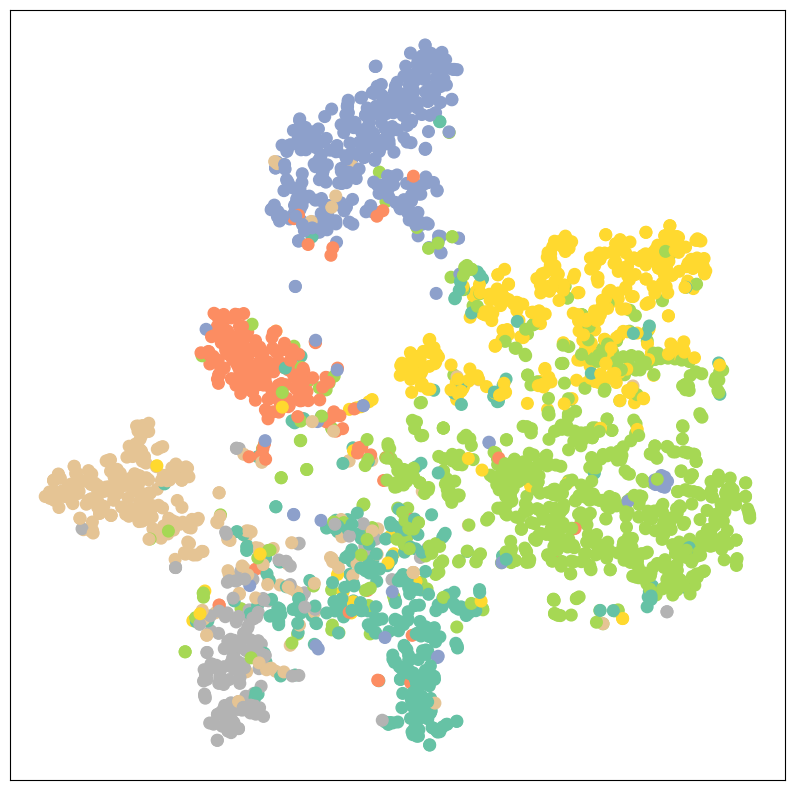

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)